In [2]:
from obspy.core import Stream, read, UTCDateTime
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path
import pandas as pd
from mudpy import forward

In [3]:
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [4]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'

stas = pd.read_csv(path + 'station_data.csv')
stas

,Sta,Lat,Lon,Depth(m)
0,BCWB,24.2184,121.6891,-192
1,TRKB,24.1614,121.6127,-192
2,NTTB,24.1728,121.5259,-175
3,SJNB,24.1073,121.6006,-193
4,HGSB,23.4903,121.4237,-266
5,CHMB,23.4868,121.4703,-191
6,SSNB,23.4423,121.3981,-185
7,ZANB,23.3947,121.4585,-218
8,FBRB,23.1406,121.2796,-200
9,SSTB,23.1340,121.3782,-199


In [5]:
def get_cal_factor(sta):
    
    if sta == 'FBRB':
        factor = 9.8*10**(-3)
    elif sta == 'ZANB':
        factor = 7.2*10**(-3)
    elif sta == 'SSNB':
        factor = 1.6*10**(-2)
    elif sta == 'TRKB':
        factor = 9.15*10**(-3)
    elif sta == 'HGSB': 
        factor = 7.5*10**(-3)
    elif sta == 'SJNB': 
        factor = 9*10**(-3)
    elif sta == 'SSTB':
        factor = 1.7*10**(-2)
    elif sta == 'NTTB': 
        factor = 5.4*10**(-3)
    elif sta == 'DONB':
        factor = 5*10**(-2)
    elif sta == 'CHMB':
        factor = 5.7*10**(-3)
    else:
        print('Missing factor for ' + sta)
        factor = 0
        
    return factor

In [6]:
# Make list of events 

dirs_list = sorted((f for f in os.listdir(path) if not f.startswith('.')), key = str.lower)
events = dirs_list[:3]
origin_times = ['2009-10-03T17:36:06.120', '2013-10-31T12:02:08.720', '2018-02-04T13:56:41.950'] # Got from USGS website
lats = [23.630, 23.590, 24.157]
lons = [121.452, 121.437, 121.708]
depths = [28.0, 10.0, 12.0]

events = np.column_stack((np.array(events), np.array(origin_times), np.array(lats), np.array(lons), np.array(depths)))

events = pd.DataFrame(events, columns = ['evt_id', 'origin_time', 'lat', 'lon', 'depth'])
events.to_csv(path + 'events_csv.csv', index = False)

In [7]:
events['evt_id']

0    2009-10-03_M6.1
1    2013-10-31_M6.3
2    2018-02-04_M6.1
Name: evt_id, dtype: object

2009-10-03T17:36:06.120000Z
--------------
BCWB
--------------
TRKB
--------------
NTTB


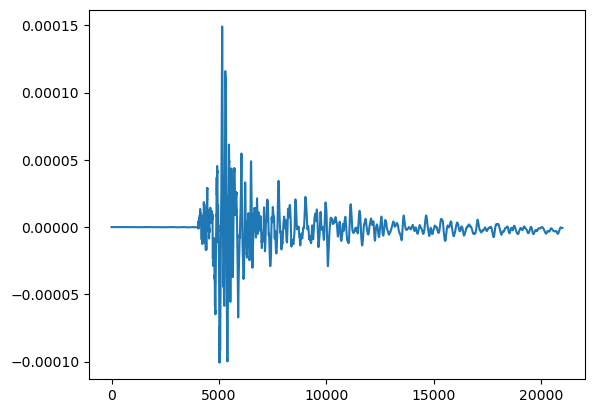

--------------
SJNB
--------------
HGSB


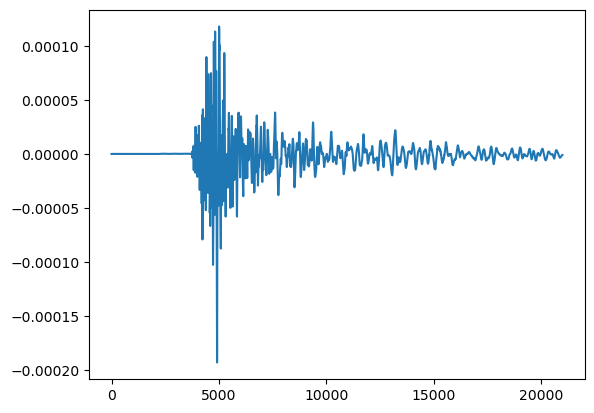

--------------
CHMB
--------------
SSNB
--------------
ZANB


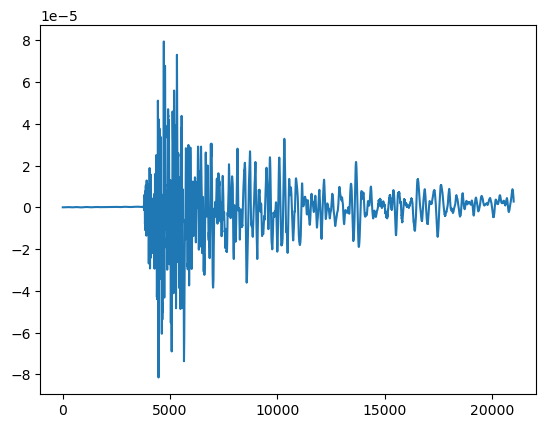

--------------
FBRB


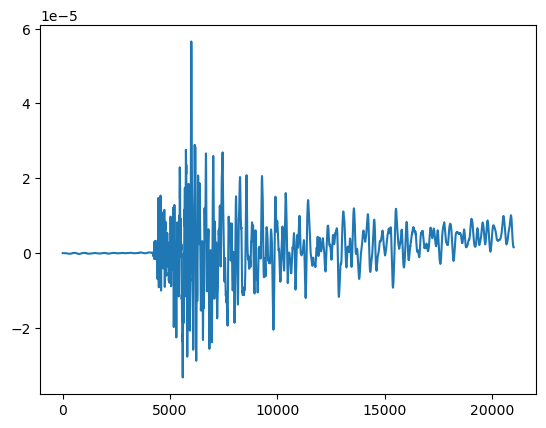

--------------
SSTB
--------------
DONB
2013-10-31T12:02:08.720000Z
--------------
BCWB
--------------
TRKB


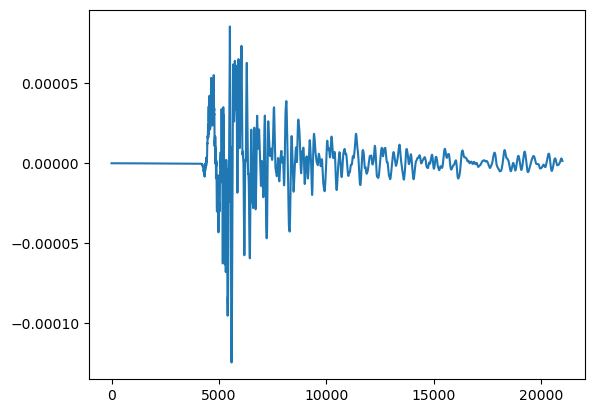

--------------
NTTB
--------------
SJNB


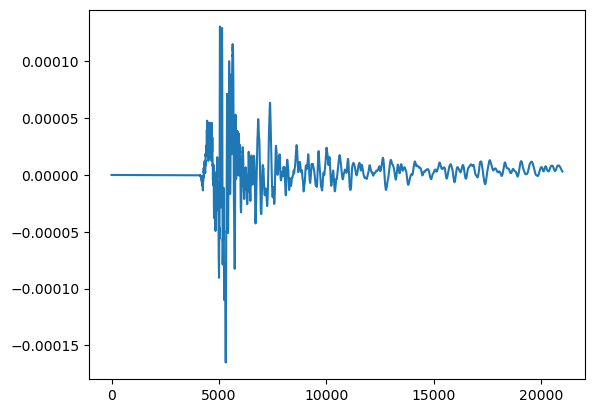

--------------
HGSB


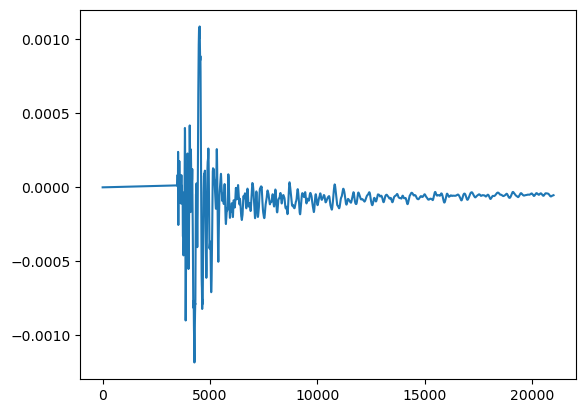

--------------
CHMB


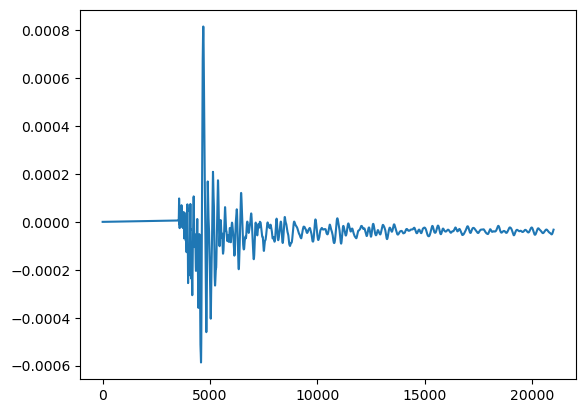

--------------
SSNB


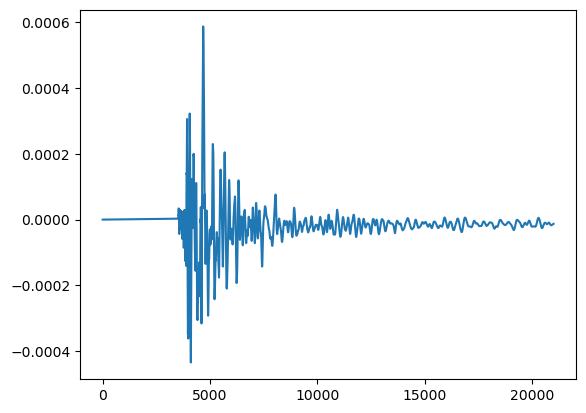

--------------
ZANB


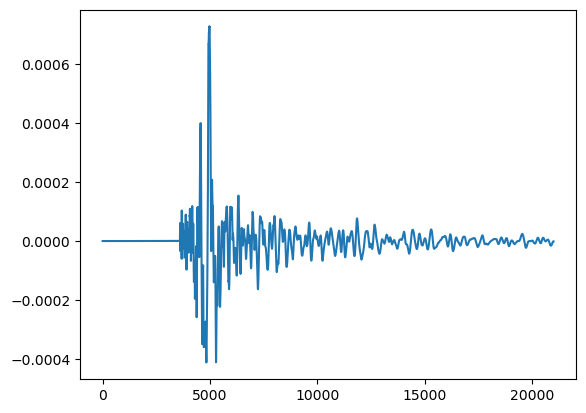

--------------
FBRB


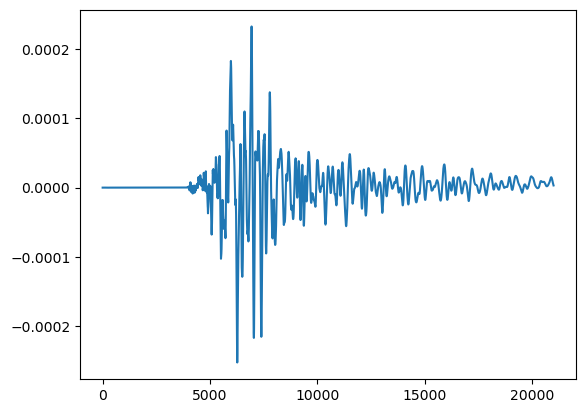

--------------
SSTB


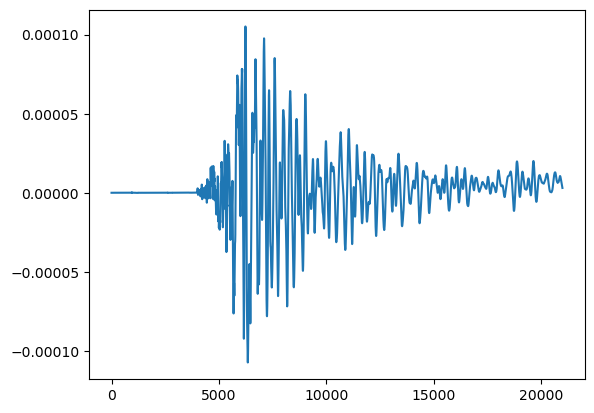

--------------
DONB


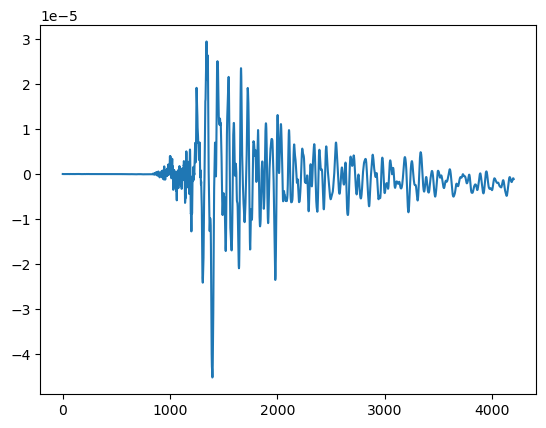

2018-02-04T13:56:41.950000Z
--------------
BCWB
--------------
TRKB


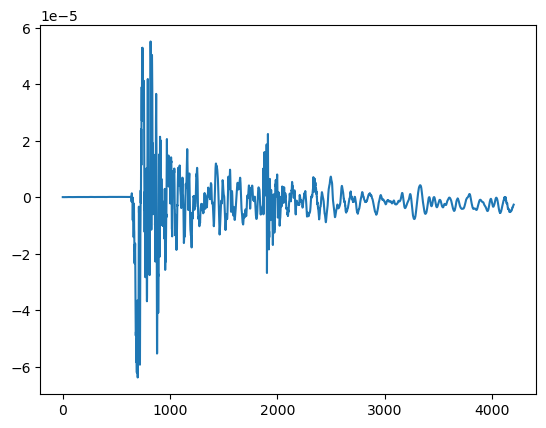

--------------
NTTB
--------------
SJNB


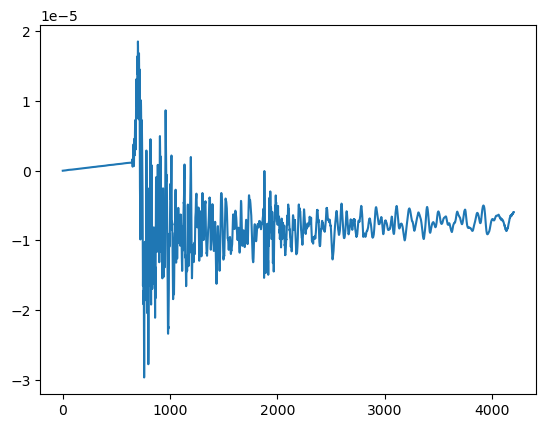

--------------
HGSB


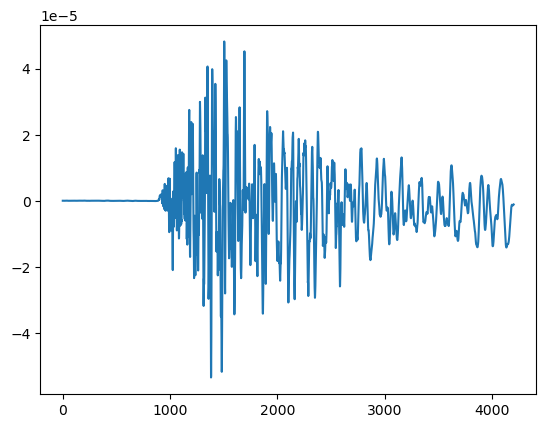

--------------
CHMB


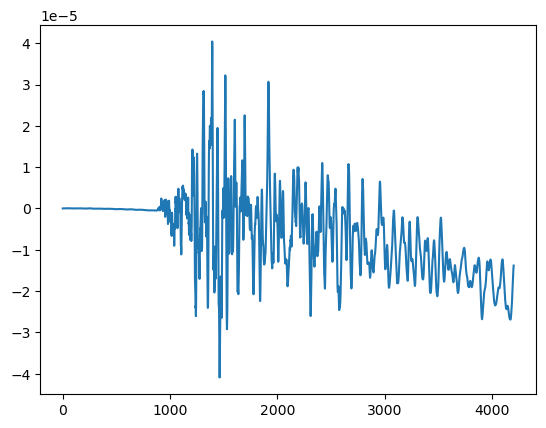

--------------
SSNB


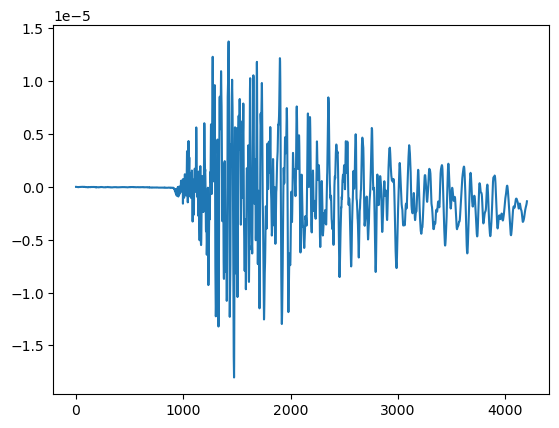

--------------
ZANB


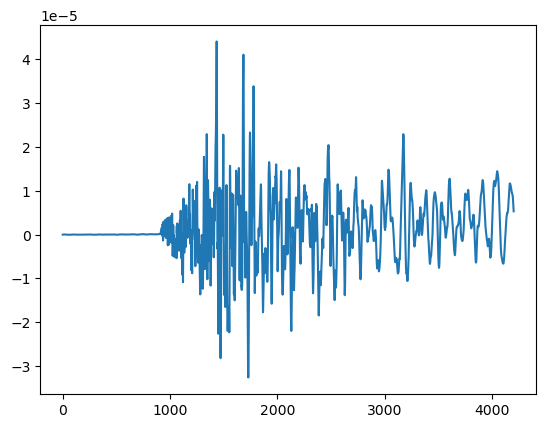

--------------
FBRB


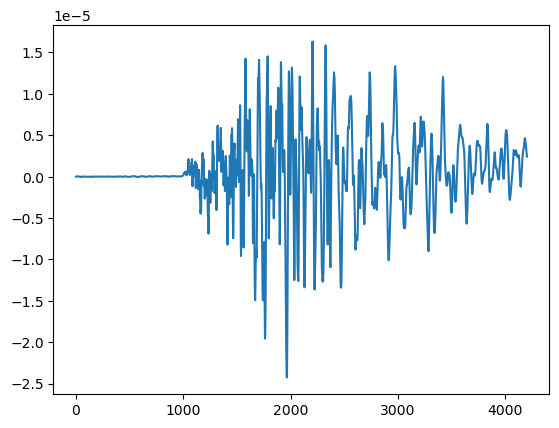

--------------
SSTB


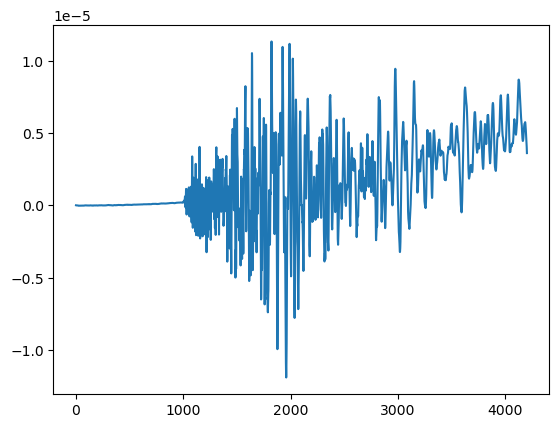

--------------
DONB


In [8]:
for i in range(len(events)):
    
    evt_id = events['evt_id'][i]
    origin_time = UTCDateTime(events['origin_time'][i])
    print(origin_time)

    for idx in range(len(stas)):

        sta = stas['Sta'][idx]
        print('--------------')
        print(sta)
        
        try: 
            ev = read(path + evt_id + '/' + sta + '.EV.sac')
            
        except:
            continue

        # ev.plot()

        starttime = origin_time - 30
        endtime = origin_time + 180
        
        ev.trim(starttime, endtime)

        # ev.plot()
        
        # Convert to nanostrain
        ev_data = ev[0].data
        factor = get_cal_factor(sta)
        if factor == 0:
            continue
        nanostrain_data = ev_data / factor
        strain_data = nanostrain_data / 10**9

        # High-pass filter
        corner_period = 1000 # seconds
        corner_freq = 1/corner_period

        filter_data = forward.highpass(strain_data, fcorner = corner_freq, fsample = ev[0].stats.sampling_rate, order = 4)

        # Detrend
        filter_data = filter_data - np.mean(filter_data[0:10])
        # plt.plot(filter_data)
        # plt.show()

# #         RMS_strain = np.sqrt(((filterS1[0].data)**2 + (filterS2[0].data)**2 + (filterS3[0].data)**2 + (filterS4[0].data)**2)/4)         

#         times = ev[0].times()

#         # plt.title(sta)
#         # plt.plot(times, ev[0].data, label = 'EV')
#         # plt.plot(times, filter_ev[0].data, label = 'Filter EV')
#         # # plt.plot(times, RMS_strain, label = 'RMS')
#         # # plt.xlim(1000, 1150)
#         # # plt.ylim(0, max(RMS_strain[1000*20:1150*20])*1.1)
#         # # plt.ylim(min(S1[0].data[1000*20:1150*20])*0.9, max(S1[0].data[1000*20:1150*20])*1.1)
#         # plt.legend()
#         # plt.show()

# #         RMS_st = filterS1.copy()
# #         RMS_st[0].stats.channel = 'RMS'
# #         RMS_st[0].data = RMS_strain

# #         RMS_st[0].plot()
#         # print(filter_ev[0].stats)
    
#         filter_data_st = ev.copy()
#         filter_data_st[0].data = filter_data
    
#         filter_data_st[0].stats.station = sta
#         # print(sta)
        
#         # print(filter_ev[0].stats)
        
#         # ev[0].plot()
#         # filter_data_st[0].plot()

#         # Create folder for the event
#         eq_sta_save_dir = path + 'filtered_uncal/' + evt_id + '/'
#         # print(eq_sta_save_dir)
#         if os.path.isdir(eq_sta_save_dir):
#             pass
#         else:
#             os.makedirs(eq_sta_save_dir)

#         filter_data_st.write(eq_sta_save_dir + sta + '.mseed', format = 'MSEED')
